In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("prosperLoanData.csv") # the full datasetb

In [3]:
data.isnull().sum()

ListingKey                         0
ListingNumber                      0
ListingCreationDate                0
CreditGrade                    84984
Term                               0
                               ...  
PercentFunded                      0
Recommendations                    0
InvestmentFromFriendsCount         0
InvestmentFromFriendsAmount        0
Investors                          0
Length: 81, dtype: int64

In [4]:
dropped = ['ListingNumber', 'LoanNumber', 'GroupKey', 'LoanKey', 'MemberKey', 'ListingKey']

In [5]:
data['CreditGrade'].values

array(['C', nan, 'HR', ..., nan, nan, nan], dtype=object)

In [6]:
dropped.extend(['ProsperRating (Alpha)','ProsperRating (numeric)'])


In [7]:
data.drop(dropped,axis=1,inplace=True)


# Filling missing values


In [8]:
data.isnull().sum().sort_values(ascending=False)

LoanFirstDefaultedCycleNumber      96985
ScorexChangeAtTimeOfListing        95009
ProsperPrincipalOutstanding        91852
ProsperPrincipalBorrowed           91852
ProsperPaymentsOneMonthPlusLate    91852
                                   ...  
LenderYield                            0
BorrowerRate                           0
LoanStatus                             0
Term                                   0
Investors                              0
Length: 73, dtype: int64

In [9]:
for col in data.select_dtypes('float64').columns:
    if data[col].isnull().sum() > 0: 
        data[col]=data[col].fillna(data[col].median())
data.select_dtypes('float64').isnull().sum().sum()


0

In [10]:
data.isnull().sum().sum()

155887

In [11]:
for col in data.select_dtypes('int64').columns: 
    if data[col].nunique() > 100:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode(), inplace=True)
data.select_dtypes('int64').isnull().sum().sum()


0

# Imputing Dates

In [12]:
date =['FirstRecordedCreditLine','DateCreditPulled','ListingCreationDate','ClosedDate','LoanOriginationDate']
# convert date columns from object to datetime 
for i in date:
    #to get ride of time convert data to datetime
    data[i]=pd.to_datetime(data[i])
    data[i]=data[i].dt.date  # datatype=object
    # split each coloumn to year month day then delet it 
    data[f'{i}_year']= pd.DatetimeIndex(data[f'{i}']).year
    data[f'{i}_month']= pd.DatetimeIndex(data[f'{i}']).month
    data[f'{i}_day']= pd.DatetimeIndex(data[f'{i}']).day
    del(data[f'{i}'])


# Detecting Outliers



In [13]:
for col in data.columns:
        if (((data[col].dtype)=='float64') | ((data[col].dtype)=='int64')):
            percentiles = data[col].quantile([0.25,0.75]).values
            iqr = percentiles[1] - percentiles[0]
            lower_bound = percentiles[0] -(1.5 * iqr) 
            upper_bound = percentiles[1] +(1.5 * iqr)
            data[col].loc[data[col] < lower_bound] = lower_bound
            data[col].loc[data[col] > upper_bound] = upper_bound
        else:
            data[col]=data[col]

/tmp/ipykernel_12166/109602084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].loc[data[col] < lower_bound] = lower_bound
/tmp/ipykernel_12166/109602084.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].loc[data[col] > upper_bound] = upper_bound


# Imputing Target Value


In [14]:
def target_handling(row): 
    if row == 'Completed':
        return 1
    else:
        return 0

data['Status'] = data['LoanStatus'].apply(target_handling)
data.drop('LoanStatus',axis=1,inplace=True)


# Encoding

In [15]:
obj = data.select_dtypes('object')
obj.nunique()

CreditGrade                8
BorrowerState             51
Occupation                67
EmploymentStatus           8
IncomeRange                8
LoanOriginationQuarter    33
dtype: int64

In [16]:
### one hot encoding
dummies = pd.get_dummies(data[['CreditGrade', 'EmploymentStatus', 'IncomeRange','LoanOriginationQuarter']], drop_first=True)


In [17]:
## label enc
le = LabelEncoder()
data[['BorrowerState','Occupation']] = data[['BorrowerState','Occupation']].apply(le.fit_transform)


In [18]:
data = pd.concat([data.drop(obj,axis=1),dummies],axis=1)

In [19]:
data.select_dtypes('object')

""
0
1
2
3
4
...
113932
113933
113934
113935


In [20]:
data

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,...,LoanOriginationQuarter_Q3 2013,LoanOriginationQuarter_Q4 2005,LoanOriginationQuarter_Q4 2006,LoanOriginationQuarter_Q4 2007,LoanOriginationQuarter_Q4 2008,LoanOriginationQuarter_Q4 2009,LoanOriginationQuarter_Q4 2010,LoanOriginationQuarter_Q4 2011,LoanOriginationQuarter_Q4 2012,LoanOriginationQuarter_Q4 2013
0,36,0.16516,0.1580,0.1380,0.16150,0.0724,0.09170,6.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,36,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,7.0,2,44.0,...,0,0,0,0,0,0,0,0,0,0
2,36,0.28269,0.2750,0.2400,0.16150,0.0724,0.09170,6.0,0,67.0,...,0,0,0,0,0,0,0,0,0,0
3,36,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,9.0,6,113.0,...,0,0,0,0,0,0,0,0,1,0
4,36,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,4.0,2,44.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,36,0.22354,0.1864,0.1764,0.16490,0.0699,0.09500,5.0,1,246.0,...,0,0,0,0,0,0,0,0,0,0
113933,36,0.13220,0.1110,0.1010,0.10070,0.0200,0.08070,8.0,6,21.0,...,0,0,0,0,0,0,0,1,0,0
113934,36,0.23984,0.2150,0.2050,0.18828,0.1025,0.08578,3.0,1,84.0,...,0,0,0,0,0,0,0,0,0,1
113935,36,0.28408,0.2605,0.2505,0.24450,0.0850,0.15142,5.0,2,94.0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
data.isnull().sum().sum()

178635

In [25]:
data.columns.get_loc('Status')

76

# Spliting the data

In [27]:
data = data.dropna(how='any',axis=0) 

In [28]:
dataset =data.iloc[:,np.r_[0:76,77:130,76]]
dataset

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,...,LoanOriginationQuarter_Q4 2005,LoanOriginationQuarter_Q4 2006,LoanOriginationQuarter_Q4 2007,LoanOriginationQuarter_Q4 2008,LoanOriginationQuarter_Q4 2009,LoanOriginationQuarter_Q4 2010,LoanOriginationQuarter_Q4 2011,LoanOriginationQuarter_Q4 2012,LoanOriginationQuarter_Q4 2013,Status
0,36,0.16516,0.1580,0.1380,0.1615,0.0724,0.09170,6.0,0,2.0,...,0,0,0,0,0,0,0,0,0,1
2,36,0.28269,0.2750,0.2400,0.1615,0.0724,0.09170,6.0,0,67.0,...,0,0,0,0,0,0,0,0,0,1
11,36,0.15033,0.1325,0.1225,0.1615,0.0724,0.09170,6.0,0,19.0,...,0,0,1,0,0,0,0,0,0,1
15,36,0.35797,0.3177,0.3077,0.2891,0.1614,0.12460,5.0,6,121.0,...,0,0,0,0,0,0,0,0,0,0
17,36,0.13202,0.1250,0.1175,0.1615,0.0724,0.09170,6.0,0,67.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113926,36,0.29776,0.2900,0.2850,0.1615,0.0724,0.09170,6.0,0,67.0,...,0,0,0,0,0,0,0,0,0,0
113927,36,0.07469,0.0679,0.0579,0.1615,0.0724,0.09170,6.0,4,69.0,...,0,0,0,0,0,0,0,0,0,1
113928,36,0.22362,0.1899,0.1799,0.1757,0.0610,0.11470,6.0,3,22.0,...,0,0,0,0,0,0,0,0,0,1
113929,36,0.30285,0.2639,0.2539,0.2318,0.1225,0.10930,3.0,2,25.0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
dataset = dataset.values

In [31]:
X= dataset[:,0:129]

In [43]:
X

array([[36, 0.16516, 0.158, ..., 0, 0, 0],
       [36, 0.28269, 0.275, ..., 0, 0, 0],
       [36, 0.15033, 0.1325, ..., 0, 0, 0],
       ...,
       [36, 0.22362, 0.1899, ..., 0, 0, 0],
       [36, 0.30285, 0.2639, ..., 0, 0, 0],
       [36, 0.28408, 0.2605, ..., 1, 0, 0]], dtype=object)

In [49]:
y = dataset[:,129]
y =np.array(y, dtype='float')

# Preprocessing 

In [50]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [51]:
X_scale

array([[0.        , 0.38002491, 0.43888889, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.66158785, 0.76388889, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.34449715, 0.36805556, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.5200757 , 0.5275    , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.70988453, 0.73305556, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.66491783, 0.72361111, ..., 1.        , 0.        ,
        0.        ]])

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scale, y, test_size=0.3)

In [53]:
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

# Neural Nets 

In [38]:
from keras.models import Sequential
from keras.layers import Dense

2022-07-28 10:54:16.061429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 10:54:16.061463: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Model1


In [ ]:

model = Sequential([
    Dense(1000, activation='relu', input_shape=(129,)),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [57]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
hist = model.fit(X_train, y_train,
          batch_size=32, epochs=50,
          validation_data=(X_val, y_val))

Epoch 1/50
1190/1190 [==============================] - 31s 25ms/step - loss: 0.1807 - accuracy: 0.9304 - val_loss: 0.1403 - val_accuracy: 0.9543
Epoch 2/50
1190/1190 [==============================] - 40s 34ms/step - loss: 0.1145 - accuracy: 0.9607 - val_loss: 0.1177 - val_accuracy: 0.9588
Epoch 3/50
1190/1190 [==============================] - 39s 32ms/step - loss: 0.1003 - accuracy: 0.9663 - val_loss: 0.0999 - val_accuracy: 0.9657
Epoch 4/50
1190/1190 [==============================] - 38s 32ms/step - loss: 0.0912 - accuracy: 0.9696 - val_loss: 0.1137 - val_accuracy: 0.9648
Epoch 5/50
1190/1190 [==============================] - 35s 29ms/step - loss: 0.0828 - accuracy: 0.9732 - val_loss: 0.0933 - val_accuracy: 0.9711
Epoch 6/50
1190/1190 [==============================] - 37s 31ms/step - loss: 0.0787 - accuracy: 0.9739 - val_loss: 0.0876 - val_accuracy: 0.9745
Epoch 7/50
1190/1190 [==============================] - 38s 32ms/step - loss: 0.0732 - accuracy: 0.9763 - val_loss: 0.0778 -

In [68]:
model.evaluate(X_test, y_test)[1]

255/255 [==============================] - 2s 6ms/step - loss: 0.1410 - accuracy: 0.9759


0.9758548736572266

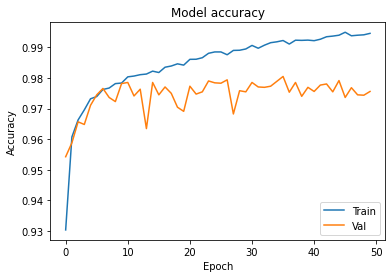

In [62]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

### The Graph is showing that our model is overfitting
### Let's  add some dropout layeres to solve this problem

# Model2

In [65]:
from keras.layers import Dropout
model2 = Sequential([
    Dense(1000, activation='relu', input_shape=(129,)),
    Dropout(0.3),
    Dense(1000, activation='relu'),
    Dropout(0.3),
    Dense(1000, activation='relu'),
    Dropout(0.3),
    Dense(1000, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

In [66]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
hist2 = model2.fit(X_train, y_train,
          batch_size=32, epochs=50,
          validation_data=(X_val, y_val))

Epoch 1/50
1190/1190 [==============================] - 41s 34ms/step - loss: 0.2124 - accuracy: 0.9173 - val_loss: 0.1707 - val_accuracy: 0.9484
Epoch 2/50
1190/1190 [==============================] - 38s 32ms/step - loss: 0.1358 - accuracy: 0.9530 - val_loss: 0.1061 - val_accuracy: 0.9643
Epoch 3/50
1190/1190 [==============================] - 44s 37ms/step - loss: 0.1229 - accuracy: 0.9579 - val_loss: 0.1974 - val_accuracy: 0.9381
Epoch 4/50
1190/1190 [==============================] - 40s 33ms/step - loss: 0.1110 - accuracy: 0.9645 - val_loss: 0.0903 - val_accuracy: 0.9716
Epoch 5/50
1190/1190 [==============================] - 44s 37ms/step - loss: 0.1016 - accuracy: 0.9675 - val_loss: 0.0902 - val_accuracy: 0.9696
Epoch 6/50
1190/1190 [==============================] - 42s 35ms/step - loss: 0.0999 - accuracy: 0.9685 - val_loss: 0.1485 - val_accuracy: 0.9402
Epoch 7/50
1190/1190 [==============================] - 42s 35ms/step - loss: 0.0962 - accuracy: 0.9692 - val_loss: 0.1038 -

# evaluation of model2

In [69]:
model2.evaluate(X_test, y_test)[1]

255/255 [==============================] - 2s 6ms/step - loss: 0.0824 - accuracy: 0.9774


0.9774482250213623

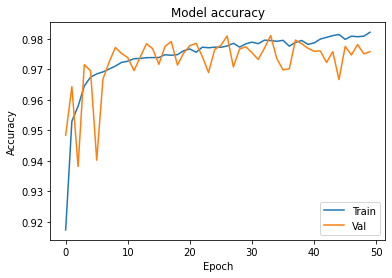

In [70]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

### we’ve reduced overfitting substantially! And that’s how we apply our regularization techniques to reduce overfitting to the training set and we obtained an accuracy of 97% on the testdataset